In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
df = df.loc[df['Stats'].isin([1.e+08, 2.e+08, 5.e+08])]

df['Stats'].unique()

array([1.e+08, 2.e+08, 5.e+08])

In [6]:
crystals = np.array(df['Crystal'].unique())

df['Crystal'].unique()

array(['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
       'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
       'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
       'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3'], dtype=object)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

Stats = df['Stats']

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

Diff_train, Diff_test, Stats_train, Stats_test, y_train, y_test = train_test_split(X, Stats, y_encoded, test_size=0.1, random_state=42)

In [8]:
import torch.nn.functional as F

# Преобразование матриц в numpy массив перед преобразованием в тензоры
Diff_train_matrices = np.array(Diff_train['Matrix'].tolist())
Diff_test_matrices = np.array(Diff_test['Matrix'].tolist())

Stats_train_matrices = np.array(Stats_train.tolist())
Stats_test_matrices = np.array(Stats_test.tolist())

# Преобразование данных в тензоры PyTorch
Diff_train_tensor = torch.FloatTensor(Diff_train_matrices)
Diff_train_tensor = Diff_train_tensor.unsqueeze(1)
#Diff_train_tensor = F.interpolate(Diff_train_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_train_tensor = Diff_train_tensor * 2.0 - 1.0
Stats_train_tensor = torch.FloatTensor(Stats_train_matrices)

y_train_tensor = torch.LongTensor(y_train)  # Используем LongTensor для целевых меток

Diff_test_tensor = torch.FloatTensor(Diff_test_matrices)
Diff_test_tensor = Diff_test_tensor.unsqueeze(1)
#Diff_test_tensor = F.interpolate(Diff_test_tensor, size=(256, 480), mode='bicubic', align_corners=False)
Diff_test_tensor = Diff_test_tensor * 2.0 - 1.0
Stats_test_tensor = torch.FloatTensor(Stats_test_matrices)

y_test_tensor = torch.LongTensor(y_test)

In [9]:
print(Diff_train_tensor.size())
print(Diff_test_tensor.size())

torch.Size([1620, 1, 250, 480])
torch.Size([180, 1, 250, 480])


In [10]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Создание набора данных
train_dataset = TensorDataset(Diff_train_tensor, y_train_tensor)

test_dataset = TensorDataset(Diff_test_tensor, y_test_tensor)

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
from Conditional_Vector_ViT_VAE_model import ViTVAE, vae_loss, vae_loss_free_bits

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration
model = ViTVAE(
    img_size=(250, 480),
    patch_size=(10, 16),  # 25x30 patches
    in_channels=1,
    embed_dim=512,
    depth=6,
    num_heads=8,
    num_classes=30,
    latent_dim=256,
    dropout=0.1,
    condition_type="cross_attn", # "add" "cross_attn"
    condition_mode="multi" # "single" "multi"
).to(device)

# fake batch
data = torch.randn(4, 1, 250, 480, device=device)
labels = torch.randint(0, 20, (4,), device=device)

recon_data, mean, logvar = model(data, labels)

print(recon_data.size(), mean.size(), logvar.size())

torch.Size([4, 1, 250, 480]) torch.Size([4, 256]) torch.Size([4, 256])


In [12]:
model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Multi_CrossAtt.pth"))
model.to(device)

ViTVAE(
  (encoder): ViTEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(1, 512, kernel_size=(10, 16), stride=(10, 16))
    )
    (condition): ConditionBlock(
      (class_embed): Embedding(30, 512)
      (cross_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (pos_embed): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none

In [13]:
num_epochs = 200
num_epochs_fine_tune = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,  # Чуть выше начальный LR
    betas=(0.9, 0.999),
    eps=1e-8,  # Стандартное значение
    weight_decay=1e-4  # Увеличьте weight decay для лучшей регуляризации
)

In [13]:
def beta_schedule(epoch):
    return min(1.0, epoch / 50)

from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
accum_steps = 12

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()

    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0

    beta = beta_schedule(epoch)

    for step, (x_batch, labels) in enumerate(tqdm(train_loader)):

        x_batch = x_batch.to(device)
        labels = labels.to(device)

        with autocast():
            x_recon, mu, logvar = model(x_batch, labels)

            (
                loss,
                recon_loss,
                kl_loss
            ) = vae_loss_free_bits(
                x_recon=x_recon,
                x=x_batch,
                mu=mu,
                logvar=logvar,
                free_bits_threshold=0.01,
                beta=beta
            )

            loss = loss / accum_steps

        scaler.scale(loss).backward()

        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    # --- если не кратно accum_steps ---
    if (step + 1) % accum_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    n = len(train_loader)

    print(
        f"Epoch {epoch:03d} | "
        f"Loss: {total_loss/n:.4f} | "
        f"Recon: {total_recon/n:.4f} | "
        f"KL: {total_kl/n:.4f} | "
        f"β={beta:.2f}, "
    )


C:\Users\neUral\AppData\Local\Temp\ipykernel_13868\3788628174.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/162 [00:00<?, ?it/s]C:\Users\neUral\AppData\Local\Temp\ipykernel_13868\3788628174.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 162/162 [00:45<00:00,  3.54it/s]


Epoch 000 | Loss: 0.5813 | Recon: 0.5813 | KL: 0.5025 | β=0.00, 


100%|██████████| 162/162 [00:48<00:00,  3.36it/s]


Epoch 001 | Loss: 0.2128 | Recon: 0.2062 | KL: 0.3307 | β=0.02, 


100%|██████████| 162/162 [00:44<00:00,  3.64it/s]


Epoch 002 | Loss: 0.1764 | Recon: 0.1718 | KL: 0.1148 | β=0.04, 


100%|██████████| 162/162 [00:48<00:00,  3.36it/s]


Epoch 003 | Loss: 0.1575 | Recon: 0.1507 | KL: 0.1138 | β=0.06, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 004 | Loss: 0.1436 | Recon: 0.1394 | KL: 0.0519 | β=0.08, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 005 | Loss: 0.1381 | Recon: 0.1347 | KL: 0.0348 | β=0.10, 


100%|██████████| 162/162 [00:49<00:00,  3.31it/s]


Epoch 006 | Loss: 0.1320 | Recon: 0.1265 | KL: 0.0460 | β=0.12, 


100%|██████████| 162/162 [00:47<00:00,  3.38it/s]


Epoch 007 | Loss: 0.1256 | Recon: 0.1189 | KL: 0.0475 | β=0.14, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 008 | Loss: 0.1219 | Recon: 0.1144 | KL: 0.0468 | β=0.16, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 009 | Loss: 0.1204 | Recon: 0.1125 | KL: 0.0442 | β=0.18, 


100%|██████████| 162/162 [00:45<00:00,  3.60it/s]


Epoch 010 | Loss: 0.1193 | Recon: 0.1111 | KL: 0.0411 | β=0.20, 


100%|██████████| 162/162 [00:45<00:00,  3.56it/s]


Epoch 011 | Loss: 0.1192 | Recon: 0.1103 | KL: 0.0404 | β=0.22, 


100%|██████████| 162/162 [00:48<00:00,  3.36it/s]


Epoch 012 | Loss: 0.1191 | Recon: 0.1099 | KL: 0.0383 | β=0.24, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 013 | Loss: 0.1177 | Recon: 0.1081 | KL: 0.0367 | β=0.26, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 014 | Loss: 0.1148 | Recon: 0.1048 | KL: 0.0357 | β=0.28, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 015 | Loss: 0.1127 | Recon: 0.1025 | KL: 0.0341 | β=0.30, 


100%|██████████| 162/162 [00:45<00:00,  3.54it/s]


Epoch 016 | Loss: 0.1107 | Recon: 0.1003 | KL: 0.0327 | β=0.32, 


100%|██████████| 162/162 [00:44<00:00,  3.65it/s]


Epoch 017 | Loss: 0.1098 | Recon: 0.0991 | KL: 0.0315 | β=0.34, 


100%|██████████| 162/162 [00:44<00:00,  3.65it/s]


Epoch 018 | Loss: 0.1084 | Recon: 0.0972 | KL: 0.0311 | β=0.36, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 019 | Loss: 0.1082 | Recon: 0.0968 | KL: 0.0298 | β=0.38, 


100%|██████████| 162/162 [00:49<00:00,  3.30it/s]


Epoch 020 | Loss: 0.1068 | Recon: 0.0947 | KL: 0.0303 | β=0.40, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 021 | Loss: 0.1059 | Recon: 0.0943 | KL: 0.0278 | β=0.42, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 022 | Loss: 0.1047 | Recon: 0.0926 | KL: 0.0275 | β=0.44, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 023 | Loss: 0.1045 | Recon: 0.0923 | KL: 0.0267 | β=0.46, 


100%|██████████| 162/162 [00:49<00:00,  3.30it/s]


Epoch 024 | Loss: 0.1026 | Recon: 0.0902 | KL: 0.0258 | β=0.48, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 025 | Loss: 0.1009 | Recon: 0.0886 | KL: 0.0245 | β=0.50, 


100%|██████████| 162/162 [00:48<00:00,  3.36it/s]


Epoch 026 | Loss: 0.0998 | Recon: 0.0879 | KL: 0.0228 | β=0.52, 


100%|██████████| 162/162 [00:44<00:00,  3.63it/s]


Epoch 027 | Loss: 0.1001 | Recon: 0.0875 | KL: 0.0234 | β=0.54, 


100%|██████████| 162/162 [00:46<00:00,  3.49it/s]


Epoch 028 | Loss: 0.0994 | Recon: 0.0869 | KL: 0.0225 | β=0.56, 


100%|██████████| 162/162 [00:48<00:00,  3.32it/s]


Epoch 029 | Loss: 0.1002 | Recon: 0.0877 | KL: 0.0215 | β=0.58, 


100%|██████████| 162/162 [00:48<00:00,  3.32it/s]


Epoch 030 | Loss: 0.0983 | Recon: 0.0858 | KL: 0.0210 | β=0.60, 


100%|██████████| 162/162 [00:46<00:00,  3.47it/s]


Epoch 031 | Loss: 0.0978 | Recon: 0.0850 | KL: 0.0205 | β=0.62, 


100%|██████████| 162/162 [00:47<00:00,  3.39it/s]


Epoch 032 | Loss: 0.0966 | Recon: 0.0844 | KL: 0.0190 | β=0.64, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 033 | Loss: 0.0960 | Recon: 0.0836 | KL: 0.0188 | β=0.66, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 034 | Loss: 0.0959 | Recon: 0.0837 | KL: 0.0178 | β=0.68, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 035 | Loss: 0.0947 | Recon: 0.0827 | KL: 0.0171 | β=0.70, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 036 | Loss: 0.0943 | Recon: 0.0822 | KL: 0.0168 | β=0.72, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 037 | Loss: 0.0942 | Recon: 0.0822 | KL: 0.0162 | β=0.74, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 038 | Loss: 0.0939 | Recon: 0.0817 | KL: 0.0161 | β=0.76, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 039 | Loss: 0.0936 | Recon: 0.0816 | KL: 0.0153 | β=0.78, 


100%|██████████| 162/162 [00:46<00:00,  3.51it/s]


Epoch 040 | Loss: 0.0931 | Recon: 0.0809 | KL: 0.0152 | β=0.80, 


100%|██████████| 162/162 [00:44<00:00,  3.62it/s]


Epoch 041 | Loss: 0.0923 | Recon: 0.0805 | KL: 0.0145 | β=0.82, 


100%|██████████| 162/162 [00:44<00:00,  3.64it/s]


Epoch 042 | Loss: 0.0909 | Recon: 0.0793 | KL: 0.0139 | β=0.84, 


100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


Epoch 043 | Loss: 0.0910 | Recon: 0.0793 | KL: 0.0137 | β=0.86, 


100%|██████████| 162/162 [00:48<00:00,  3.32it/s]


Epoch 044 | Loss: 0.0909 | Recon: 0.0789 | KL: 0.0137 | β=0.88, 


100%|██████████| 162/162 [00:49<00:00,  3.31it/s]


Epoch 045 | Loss: 0.0904 | Recon: 0.0786 | KL: 0.0131 | β=0.90, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 046 | Loss: 0.0899 | Recon: 0.0776 | KL: 0.0134 | β=0.92, 


100%|██████████| 162/162 [00:44<00:00,  3.65it/s]


Epoch 047 | Loss: 0.0892 | Recon: 0.0774 | KL: 0.0126 | β=0.94, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 048 | Loss: 0.0892 | Recon: 0.0770 | KL: 0.0126 | β=0.96, 


100%|██████████| 162/162 [00:45<00:00,  3.60it/s]


Epoch 049 | Loss: 0.0890 | Recon: 0.0767 | KL: 0.0125 | β=0.98, 


100%|██████████| 162/162 [00:48<00:00,  3.34it/s]


Epoch 050 | Loss: 0.0883 | Recon: 0.0761 | KL: 0.0122 | β=1.00, 


100%|██████████| 162/162 [00:48<00:00,  3.31it/s]


Epoch 051 | Loss: 0.0876 | Recon: 0.0757 | KL: 0.0120 | β=1.00, 


100%|██████████| 162/162 [00:48<00:00,  3.33it/s]


Epoch 052 | Loss: 0.0877 | Recon: 0.0752 | KL: 0.0124 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.11it/s]


Epoch 053 | Loss: 0.0870 | Recon: 0.0751 | KL: 0.0119 | β=1.00, 


100%|██████████| 162/162 [00:58<00:00,  2.75it/s]


Epoch 054 | Loss: 0.0873 | Recon: 0.0752 | KL: 0.0121 | β=1.00, 


100%|██████████| 162/162 [01:07<00:00,  2.40it/s]


Epoch 055 | Loss: 0.0864 | Recon: 0.0744 | KL: 0.0119 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.67it/s]


Epoch 056 | Loss: 0.0853 | Recon: 0.0734 | KL: 0.0119 | β=1.00, 


100%|██████████| 162/162 [00:39<00:00,  4.08it/s]


Epoch 057 | Loss: 0.0854 | Recon: 0.0736 | KL: 0.0118 | β=1.00, 


100%|██████████| 162/162 [00:37<00:00,  4.34it/s]


Epoch 058 | Loss: 0.0844 | Recon: 0.0728 | KL: 0.0116 | β=1.00, 


100%|██████████| 162/162 [00:37<00:00,  4.34it/s]


Epoch 059 | Loss: 0.0836 | Recon: 0.0720 | KL: 0.0116 | β=1.00, 


100%|██████████| 162/162 [00:40<00:00,  3.96it/s]


Epoch 060 | Loss: 0.0833 | Recon: 0.0719 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:40<00:00,  4.03it/s]


Epoch 061 | Loss: 0.0832 | Recon: 0.0716 | KL: 0.0116 | β=1.00, 


100%|██████████| 162/162 [00:46<00:00,  3.46it/s]


Epoch 062 | Loss: 0.0829 | Recon: 0.0715 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:51<00:00,  3.15it/s]


Epoch 063 | Loss: 0.0823 | Recon: 0.0707 | KL: 0.0116 | β=1.00, 


100%|██████████| 162/162 [01:22<00:00,  1.97it/s]


Epoch 064 | Loss: 0.0819 | Recon: 0.0706 | KL: 0.0113 | β=1.00, 


100%|██████████| 162/162 [01:07<00:00,  2.39it/s]


Epoch 065 | Loss: 0.0821 | Recon: 0.0705 | KL: 0.0116 | β=1.00, 


100%|██████████| 162/162 [01:07<00:00,  2.41it/s]


Epoch 066 | Loss: 0.0817 | Recon: 0.0703 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.04it/s]


Epoch 067 | Loss: 0.0807 | Recon: 0.0694 | KL: 0.0113 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 068 | Loss: 0.0806 | Recon: 0.0692 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.03it/s]


Epoch 069 | Loss: 0.0804 | Recon: 0.0690 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 070 | Loss: 0.0806 | Recon: 0.0692 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.04it/s]


Epoch 071 | Loss: 0.0804 | Recon: 0.0691 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.68it/s]


Epoch 072 | Loss: 0.0801 | Recon: 0.0690 | KL: 0.0111 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.36it/s]


Epoch 073 | Loss: 0.0797 | Recon: 0.0683 | KL: 0.0114 | β=1.00, 


100%|██████████| 162/162 [01:03<00:00,  2.55it/s]


Epoch 074 | Loss: 0.0788 | Recon: 0.0677 | KL: 0.0111 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.02it/s]


Epoch 075 | Loss: 0.0781 | Recon: 0.0672 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 076 | Loss: 0.0783 | Recon: 0.0670 | KL: 0.0113 | β=1.00, 


100%|██████████| 162/162 [00:54<00:00,  2.96it/s]


Epoch 077 | Loss: 0.0779 | Recon: 0.0667 | KL: 0.0111 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.35it/s]


Epoch 078 | Loss: 0.0777 | Recon: 0.0668 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [01:04<00:00,  2.50it/s]


Epoch 079 | Loss: 0.0771 | Recon: 0.0659 | KL: 0.0111 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 080 | Loss: 0.0769 | Recon: 0.0659 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 081 | Loss: 0.0767 | Recon: 0.0657 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 082 | Loss: 0.0767 | Recon: 0.0657 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 083 | Loss: 0.0763 | Recon: 0.0653 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 084 | Loss: 0.0760 | Recon: 0.0650 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


Epoch 085 | Loss: 0.0758 | Recon: 0.0649 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.37it/s]


Epoch 086 | Loss: 0.0757 | Recon: 0.0647 | KL: 0.0110 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.66it/s]


Epoch 087 | Loss: 0.0753 | Recon: 0.0644 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.09it/s]


Epoch 088 | Loss: 0.0750 | Recon: 0.0642 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 089 | Loss: 0.0750 | Recon: 0.0642 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [00:56<00:00,  2.85it/s]


Epoch 090 | Loss: 0.0745 | Recon: 0.0637 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.35it/s]


Epoch 091 | Loss: 0.0750 | Recon: 0.0642 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


Epoch 092 | Loss: 0.0747 | Recon: 0.0638 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 093 | Loss: 0.0743 | Recon: 0.0635 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 094 | Loss: 0.0739 | Recon: 0.0633 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 095 | Loss: 0.0740 | Recon: 0.0632 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 096 | Loss: 0.0734 | Recon: 0.0625 | KL: 0.0109 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 097 | Loss: 0.0732 | Recon: 0.0625 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [01:04<00:00,  2.50it/s]


Epoch 098 | Loss: 0.0734 | Recon: 0.0625 | KL: 0.0108 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.33it/s]


Epoch 099 | Loss: 0.0730 | Recon: 0.0623 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:59<00:00,  2.74it/s]


Epoch 100 | Loss: 0.0725 | Recon: 0.0618 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 101 | Loss: 0.0723 | Recon: 0.0616 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 102 | Loss: 0.0722 | Recon: 0.0615 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:59<00:00,  2.73it/s]


Epoch 103 | Loss: 0.0718 | Recon: 0.0612 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.32it/s]


Epoch 104 | Loss: 0.0718 | Recon: 0.0612 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.69it/s]


Epoch 105 | Loss: 0.0715 | Recon: 0.0608 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 106 | Loss: 0.0714 | Recon: 0.0608 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 107 | Loss: 0.0710 | Recon: 0.0605 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 108 | Loss: 0.0709 | Recon: 0.0603 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 109 | Loss: 0.0706 | Recon: 0.0600 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 110 | Loss: 0.0708 | Recon: 0.0602 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [01:07<00:00,  2.41it/s]


Epoch 111 | Loss: 0.0704 | Recon: 0.0598 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.36it/s]


Epoch 112 | Loss: 0.0702 | Recon: 0.0597 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:56<00:00,  2.85it/s]


Epoch 113 | Loss: 0.0705 | Recon: 0.0600 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.04it/s]


Epoch 114 | Loss: 0.0703 | Recon: 0.0599 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.06it/s]


Epoch 115 | Loss: 0.0699 | Recon: 0.0594 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.70it/s]


Epoch 116 | Loss: 0.0703 | Recon: 0.0598 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.36it/s]


Epoch 117 | Loss: 0.0703 | Recon: 0.0596 | KL: 0.0107 | β=1.00, 


100%|██████████| 162/162 [00:58<00:00,  2.77it/s]


Epoch 118 | Loss: 0.0696 | Recon: 0.0592 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.03it/s]


Epoch 119 | Loss: 0.0698 | Recon: 0.0592 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 120 | Loss: 0.0692 | Recon: 0.0587 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 121 | Loss: 0.0696 | Recon: 0.0591 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 122 | Loss: 0.0692 | Recon: 0.0586 | KL: 0.0106 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 123 | Loss: 0.0688 | Recon: 0.0584 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 124 | Loss: 0.0684 | Recon: 0.0580 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.35it/s]


Epoch 125 | Loss: 0.0682 | Recon: 0.0578 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:54<00:00,  2.97it/s]


Epoch 126 | Loss: 0.0683 | Recon: 0.0578 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 127 | Loss: 0.0681 | Recon: 0.0577 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 128 | Loss: 0.0678 | Recon: 0.0573 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [01:03<00:00,  2.56it/s]


Epoch 129 | Loss: 0.0679 | Recon: 0.0574 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.35it/s]


Epoch 130 | Loss: 0.0677 | Recon: 0.0574 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:55<00:00,  2.92it/s]


Epoch 131 | Loss: 0.0675 | Recon: 0.0570 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 132 | Loss: 0.0681 | Recon: 0.0577 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 133 | Loss: 0.0674 | Recon: 0.0570 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 134 | Loss: 0.0673 | Recon: 0.0569 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 135 | Loss: 0.0672 | Recon: 0.0567 | KL: 0.0105 | β=1.00, 


100%|██████████| 162/162 [00:55<00:00,  2.91it/s]


Epoch 136 | Loss: 0.0671 | Recon: 0.0569 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.33it/s]


Epoch 137 | Loss: 0.0670 | Recon: 0.0566 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.38it/s]


Epoch 138 | Loss: 0.0669 | Recon: 0.0564 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 139 | Loss: 0.0665 | Recon: 0.0561 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 140 | Loss: 0.0663 | Recon: 0.0559 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 141 | Loss: 0.0662 | Recon: 0.0559 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:06<00:00,  2.42it/s]


Epoch 142 | Loss: 0.0662 | Recon: 0.0559 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 143 | Loss: 0.0663 | Recon: 0.0559 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.02it/s]


Epoch 144 | Loss: 0.0660 | Recon: 0.0557 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 145 | Loss: 0.0659 | Recon: 0.0556 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 146 | Loss: 0.0658 | Recon: 0.0555 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 147 | Loss: 0.0658 | Recon: 0.0556 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 148 | Loss: 0.0655 | Recon: 0.0553 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:58<00:00,  2.77it/s]


Epoch 149 | Loss: 0.0655 | Recon: 0.0553 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 150 | Loss: 0.0656 | Recon: 0.0553 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:05<00:00,  2.47it/s]


Epoch 151 | Loss: 0.0654 | Recon: 0.0550 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.08it/s]


Epoch 152 | Loss: 0.0653 | Recon: 0.0550 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 153 | Loss: 0.0655 | Recon: 0.0551 | KL: 0.0104 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 154 | Loss: 0.0656 | Recon: 0.0552 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 155 | Loss: 0.0659 | Recon: 0.0556 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:07<00:00,  2.41it/s]


Epoch 156 | Loss: 0.0652 | Recon: 0.0549 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 157 | Loss: 0.0647 | Recon: 0.0545 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 158 | Loss: 0.0647 | Recon: 0.0545 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.09it/s]


Epoch 159 | Loss: 0.0647 | Recon: 0.0544 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 160 | Loss: 0.0644 | Recon: 0.0541 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 161 | Loss: 0.0645 | Recon: 0.0542 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.66it/s]


Epoch 162 | Loss: 0.0642 | Recon: 0.0540 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 163 | Loss: 0.0642 | Recon: 0.0540 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:02<00:00,  2.57it/s]


Epoch 164 | Loss: 0.0644 | Recon: 0.0542 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.03it/s]


Epoch 165 | Loss: 0.0644 | Recon: 0.0541 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.05it/s]


Epoch 166 | Loss: 0.0640 | Recon: 0.0538 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:56<00:00,  2.88it/s]


Epoch 167 | Loss: 0.0641 | Recon: 0.0538 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 168 | Loss: 0.0641 | Recon: 0.0538 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:03<00:00,  2.54it/s]


Epoch 169 | Loss: 0.0638 | Recon: 0.0536 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.03it/s]


Epoch 170 | Loss: 0.0640 | Recon: 0.0537 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 171 | Loss: 0.0638 | Recon: 0.0535 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 172 | Loss: 0.0635 | Recon: 0.0534 | KL: 0.0101 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 173 | Loss: 0.0635 | Recon: 0.0533 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 174 | Loss: 0.0635 | Recon: 0.0532 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


Epoch 175 | Loss: 0.0632 | Recon: 0.0530 | KL: 0.0101 | β=1.00, 


100%|██████████| 162/162 [01:08<00:00,  2.36it/s]


Epoch 176 | Loss: 0.0632 | Recon: 0.0529 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.67it/s]


Epoch 177 | Loss: 0.0631 | Recon: 0.0529 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:54<00:00,  2.99it/s]


Epoch 178 | Loss: 0.0631 | Recon: 0.0529 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 179 | Loss: 0.0632 | Recon: 0.0530 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:57<00:00,  2.82it/s]


Epoch 180 | Loss: 0.0631 | Recon: 0.0528 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.32it/s]


Epoch 181 | Loss: 0.0629 | Recon: 0.0527 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:01<00:00,  2.61it/s]


Epoch 182 | Loss: 0.0628 | Recon: 0.0526 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 183 | Loss: 0.0627 | Recon: 0.0525 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 184 | Loss: 0.0628 | Recon: 0.0526 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 185 | Loss: 0.0627 | Recon: 0.0525 | KL: 0.0103 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 186 | Loss: 0.0628 | Recon: 0.0526 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 187 | Loss: 0.0626 | Recon: 0.0524 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:06<00:00,  2.45it/s]


Epoch 188 | Loss: 0.0627 | Recon: 0.0525 | KL: 0.0101 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.35it/s]


Epoch 189 | Loss: 0.0625 | Recon: 0.0524 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:58<00:00,  2.78it/s]


Epoch 190 | Loss: 0.0623 | Recon: 0.0522 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 191 | Loss: 0.0626 | Recon: 0.0524 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


Epoch 192 | Loss: 0.0620 | Recon: 0.0518 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:00<00:00,  2.69it/s]


Epoch 193 | Loss: 0.0622 | Recon: 0.0520 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Epoch 194 | Loss: 0.0622 | Recon: 0.0521 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:59<00:00,  2.72it/s]


Epoch 195 | Loss: 0.0624 | Recon: 0.0522 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 196 | Loss: 0.0621 | Recon: 0.0519 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:53<00:00,  3.04it/s]


Epoch 197 | Loss: 0.0621 | Recon: 0.0519 | KL: 0.0102 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Epoch 198 | Loss: 0.0621 | Recon: 0.0519 | KL: 0.0101 | β=1.00, 


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]

Epoch 199 | Loss: 0.0620 | Recon: 0.0518 | KL: 0.0102 | β=1.00, 


In [14]:
def freeze_encoder_and_reset_optimizer_state(model, optimizer):
    model.encoder.eval()
    for p in model.encoder.parameters():
        p.requires_grad = False
        if p in optimizer.state:
            optimizer.state[p].clear()

In [15]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()
freeze_encoder_and_reset_optimizer_state(model, optimizer)

for epoch in range(num_epochs_fine_tune):

    model.decoder.train()

    optimizer.zero_grad()

    total_loss = 0.0

    for step, (x_batch, labels) in enumerate(tqdm(train_loader)):

        x_batch = x_batch.to(device)
        labels = labels.to(device)

        with autocast():
            # ---- frozen encoder, deterministic z ----
            with torch.no_grad():
                z, mu, logvar = model.encode(x_batch, labels)

            x_recon = model.decode(z, labels)

            recon_loss = F.mse_loss(x_recon, x_batch, reduction='mean')
            loss = recon_loss

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

    n = len(train_loader)

    print(
        f"Epoch {epoch:03d} | "
        f"Loss: {total_loss/n:.4f} | "
    )


C:\Users\neUral\AppData\Local\Temp\ipykernel_15752\3385353887.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/162 [00:00<?, ?it/s]C:\Users\neUral\AppData\Local\Temp\ipykernel_15752\3385353887.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 162/162 [00:26<00:00,  6.14it/s]


Epoch 000 | Loss: 0.0684 | 


100%|██████████| 162/162 [00:26<00:00,  6.11it/s]


Epoch 001 | Loss: 0.0577 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]


Epoch 002 | Loss: 0.0576 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 003 | Loss: 0.0581 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 004 | Loss: 0.0568 | 


100%|██████████| 162/162 [00:25<00:00,  6.29it/s]


Epoch 005 | Loss: 0.0562 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 006 | Loss: 0.0565 | 


100%|██████████| 162/162 [00:25<00:00,  6.35it/s]


Epoch 007 | Loss: 0.0578 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 008 | Loss: 0.0559 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 009 | Loss: 0.0556 | 


100%|██████████| 162/162 [00:25<00:00,  6.24it/s]


Epoch 010 | Loss: 0.0558 | 


100%|██████████| 162/162 [00:25<00:00,  6.34it/s]


Epoch 011 | Loss: 0.0549 | 


100%|██████████| 162/162 [00:25<00:00,  6.34it/s]


Epoch 012 | Loss: 0.0553 | 


100%|██████████| 162/162 [00:25<00:00,  6.46it/s]


Epoch 013 | Loss: 0.0549 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 014 | Loss: 0.0551 | 


100%|██████████| 162/162 [00:24<00:00,  6.51it/s]


Epoch 015 | Loss: 0.0570 | 


100%|██████████| 162/162 [00:25<00:00,  6.48it/s]


Epoch 016 | Loss: 0.0544 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]


Epoch 017 | Loss: 0.0541 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 018 | Loss: 0.0540 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 019 | Loss: 0.0540 | 


100%|██████████| 162/162 [00:25<00:00,  6.26it/s]


Epoch 020 | Loss: 0.0539 | 


100%|██████████| 162/162 [00:25<00:00,  6.24it/s]


Epoch 021 | Loss: 0.0555 | 


100%|██████████| 162/162 [00:26<00:00,  6.22it/s]


Epoch 022 | Loss: 0.0532 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 023 | Loss: 0.0539 | 


100%|██████████| 162/162 [00:24<00:00,  6.49it/s]


Epoch 024 | Loss: 0.0631 | 


100%|██████████| 162/162 [00:24<00:00,  6.52it/s]


Epoch 025 | Loss: 0.0536 | 


100%|██████████| 162/162 [00:26<00:00,  6.23it/s]


Epoch 026 | Loss: 0.0529 | 


100%|██████████| 162/162 [00:25<00:00,  6.28it/s]


Epoch 027 | Loss: 0.0534 | 


100%|██████████| 162/162 [00:25<00:00,  6.37it/s]


Epoch 028 | Loss: 0.0532 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]


Epoch 029 | Loss: 0.0530 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 030 | Loss: 0.0532 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 031 | Loss: 0.0531 | 


100%|██████████| 162/162 [00:25<00:00,  6.33it/s]


Epoch 032 | Loss: 0.0541 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 033 | Loss: 0.0528 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 034 | Loss: 0.0526 | 


100%|██████████| 162/162 [00:25<00:00,  6.46it/s]


Epoch 035 | Loss: 0.0524 | 


100%|██████████| 162/162 [00:26<00:00,  6.22it/s]


Epoch 036 | Loss: 0.0523 | 


100%|██████████| 162/162 [00:24<00:00,  6.49it/s]


Epoch 037 | Loss: 0.0523 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 038 | Loss: 0.0517 | 


100%|██████████| 162/162 [00:25<00:00,  6.26it/s]


Epoch 039 | Loss: 0.0525 | 


100%|██████████| 162/162 [00:26<00:00,  6.13it/s]


Epoch 040 | Loss: 0.0518 | 


100%|██████████| 162/162 [00:26<00:00,  6.18it/s]


Epoch 041 | Loss: 0.0518 | 


100%|██████████| 162/162 [00:25<00:00,  6.48it/s]


Epoch 042 | Loss: 0.0520 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 043 | Loss: 0.0519 | 


100%|██████████| 162/162 [00:26<00:00,  6.21it/s]


Epoch 044 | Loss: 0.0518 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 045 | Loss: 0.0519 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 046 | Loss: 0.0518 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 047 | Loss: 0.0523 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 048 | Loss: 0.0519 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 049 | Loss: 0.0552 | 


100%|██████████| 162/162 [00:25<00:00,  6.32it/s]


Epoch 050 | Loss: 0.0520 | 


100%|██████████| 162/162 [00:25<00:00,  6.48it/s]


Epoch 051 | Loss: 0.0519 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 052 | Loss: 0.0518 | 


100%|██████████| 162/162 [00:25<00:00,  6.33it/s]


Epoch 053 | Loss: 0.0517 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 054 | Loss: 0.0520 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 055 | Loss: 0.0515 | 


100%|██████████| 162/162 [00:25<00:00,  6.35it/s]


Epoch 056 | Loss: 0.0516 | 


100%|██████████| 162/162 [00:26<00:00,  6.18it/s]


Epoch 057 | Loss: 0.0534 | 


100%|██████████| 162/162 [00:25<00:00,  6.32it/s]


Epoch 058 | Loss: 0.0519 | 


100%|██████████| 162/162 [00:25<00:00,  6.40it/s]


Epoch 059 | Loss: 0.0517 | 


100%|██████████| 162/162 [00:25<00:00,  6.48it/s]


Epoch 060 | Loss: 0.0512 | 


100%|██████████| 162/162 [00:25<00:00,  6.46it/s]


Epoch 061 | Loss: 0.0511 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 062 | Loss: 0.0513 | 


100%|██████████| 162/162 [00:26<00:00,  6.14it/s]


Epoch 063 | Loss: 0.0511 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 064 | Loss: 0.0517 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 065 | Loss: 0.0514 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]


Epoch 066 | Loss: 0.0509 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 067 | Loss: 0.0511 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 068 | Loss: 0.0510 | 


100%|██████████| 162/162 [00:25<00:00,  6.40it/s]


Epoch 069 | Loss: 0.0514 | 


100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Epoch 070 | Loss: 0.0510 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 071 | Loss: 0.0544 | 


100%|██████████| 162/162 [00:24<00:00,  6.49it/s]


Epoch 072 | Loss: 0.0557 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 073 | Loss: 0.0513 | 


100%|██████████| 162/162 [00:25<00:00,  6.30it/s]


Epoch 074 | Loss: 0.0512 | 


100%|██████████| 162/162 [00:25<00:00,  6.36it/s]


Epoch 075 | Loss: 0.0509 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 076 | Loss: 0.0508 | 


100%|██████████| 162/162 [00:25<00:00,  6.41it/s]


Epoch 077 | Loss: 0.0509 | 


100%|██████████| 162/162 [00:25<00:00,  6.32it/s]


Epoch 078 | Loss: 0.0509 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 079 | Loss: 0.0507 | 


100%|██████████| 162/162 [00:25<00:00,  6.47it/s]


Epoch 080 | Loss: 0.0508 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 081 | Loss: 0.0507 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 082 | Loss: 0.0513 | 


100%|██████████| 162/162 [00:25<00:00,  6.41it/s]


Epoch 083 | Loss: 0.0510 | 


100%|██████████| 162/162 [00:25<00:00,  6.35it/s]


Epoch 084 | Loss: 0.0511 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]


Epoch 085 | Loss: 0.0515 | 


100%|██████████| 162/162 [00:25<00:00,  6.39it/s]


Epoch 086 | Loss: 0.0508 | 


100%|██████████| 162/162 [00:25<00:00,  6.35it/s]


Epoch 087 | Loss: 0.0505 | 


100%|██████████| 162/162 [00:25<00:00,  6.37it/s]


Epoch 088 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Epoch 089 | Loss: 0.0508 | 


100%|██████████| 162/162 [00:25<00:00,  6.48it/s]


Epoch 090 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:25<00:00,  6.32it/s]


Epoch 091 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:25<00:00,  6.44it/s]


Epoch 092 | Loss: 0.0528 | 


100%|██████████| 162/162 [00:25<00:00,  6.42it/s]


Epoch 093 | Loss: 0.0511 | 


100%|██████████| 162/162 [00:25<00:00,  6.43it/s]


Epoch 094 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:24<00:00,  6.48it/s]


Epoch 095 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Epoch 096 | Loss: 0.0506 | 


100%|██████████| 162/162 [00:25<00:00,  6.41it/s]


Epoch 097 | Loss: 0.0505 | 


100%|██████████| 162/162 [00:25<00:00,  6.35it/s]


Epoch 098 | Loss: 0.0507 | 


100%|██████████| 162/162 [00:25<00:00,  6.38it/s]

Epoch 099 | Loss: 0.0507 | 


In [21]:
# допустим, твоя текущая модель называется vae
save_path = "models/Conditional_Vector_ViT_VAE_Multi_CrossAtt.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Модель сохранена в {save_path}")

✅ Модель сохранена в models/Conditional_Vector_ViT_VAE_Multi_CrossAtt.pth


In [22]:
model.load_state_dict(torch.load("models/Conditional_Vector_ViT_VAE_Multi_CrossAtt.pth"))
model.to(device)

ViTVAE(
  (encoder): ViTEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(1, 512, kernel_size=(10, 16), stride=(10, 16))
    )
    (condition): ConditionBlock(
      (class_embed): Embedding(30, 512)
      (cross_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (pos_embed): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none

100%|██████████| 162/162 [00:19<00:00,  8.28it/s]


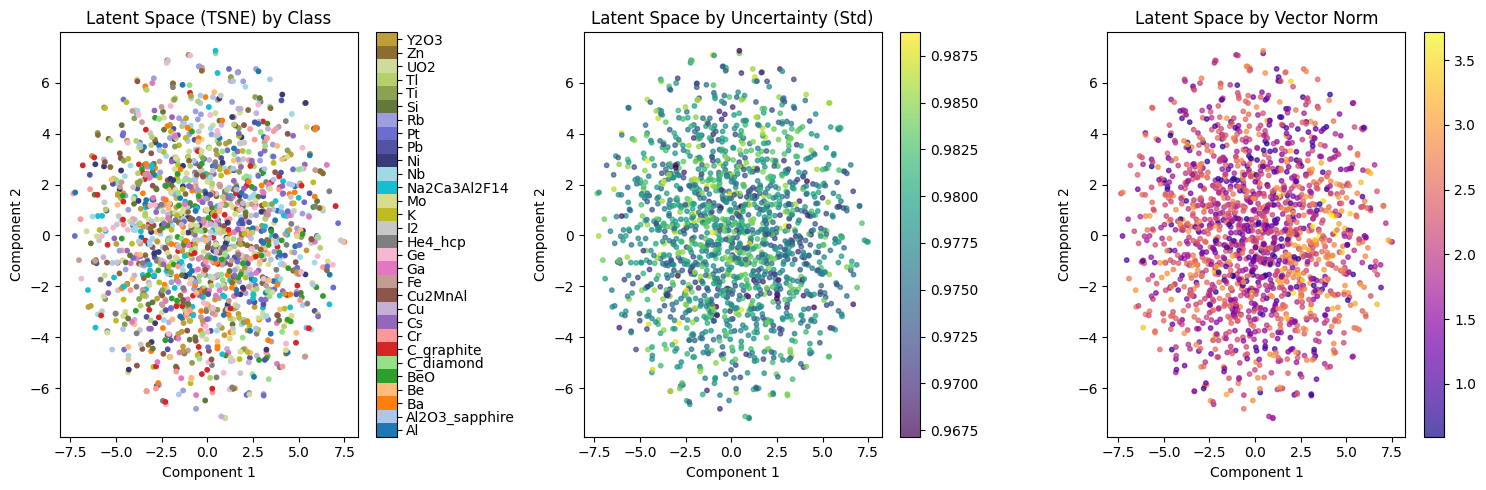

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

def visualize_latent_space(model, dataloader, device, method='tsne', class_names=None):
    model.eval()
    all_latents = []
    all_labels = []
    all_means = []
    all_logvars = []

    with torch.no_grad():
        for data, labels in tqdm(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            mean, logvar = model.encoder(data, labels)
            z = model.reparameterize(mean, logvar)

            all_latents.append(z.cpu().numpy())
            all_means.append(mean.cpu().numpy())
            all_logvars.append(logvar.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_latents = np.vstack(all_latents)
    all_means = np.vstack(all_means)
    all_labels = np.concatenate(all_labels)

    # Выбор метода снижения размерности
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)

    latents_2d = reducer.fit_transform(all_latents)

    # Визуализация
    plt.figure(figsize=(15, 5))

    plt.subplot(131)

    # Получаем уникальные классы и их количество
    unique_labels = np.unique(all_labels)
    n_classes = len(unique_labels)

    base_colors = (
        list(plt.cm.tab20.colors) +
        list(plt.cm.tab20b.colors) +
        list(plt.cm.tab20c.colors)
    )

    cmap = ListedColormap(base_colors[:n_classes])

    scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1],
                         c=all_labels,
                         cmap=cmap,
                         s=10,
                         vmin=-0.5,
                         vmax=n_classes-0.5)

    # Создаем colorbar с названиями классов
    cbar = plt.colorbar(scatter, ticks=range(n_classes))

    # Если переданы названия классов, используем их
    if class_names is not None:
        # Проверяем, что количество названий соответствует количеству классов
        if len(class_names) >= n_classes:
            cbar.ax.set_yticklabels([class_names[i] for i in range(n_classes)])
        else:
            print(f"Предупреждение: class_names содержит {len(class_names)} элементов, но есть {n_classes} классов")
            # Используем индексы как fallback
            cbar.ax.set_yticklabels([str(i) for i in range(n_classes)])
    else:
        # Если названий нет, используем просто индексы
        cbar.ax.set_yticklabels([str(i) for i in range(n_classes)])

    plt.title(f'Latent Space ({method.upper()}) by Class')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.subplot(132)
    # Визуализация неопределенности (std = exp(0.5 * logvar))
    stds = np.exp(0.5 * np.vstack(all_logvars)).mean(axis=1)
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=stds,
                         cmap='viridis', alpha=0.7, s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space by Uncertainty (Std)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.subplot(133)
    # Нормы латентных векторов
    norms = np.linalg.norm(all_means, axis=1)
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=norms,
                         cmap='plasma', alpha=0.7, s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space by Vector Norm')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()

    return all_latents, all_labels, latents_2d

# Использование
latents, labels, latents_2d = visualize_latent_space(model, train_loader, device, method='tsne', class_names=crystals)

In [16]:
#array([1.e+07, 2.e+07, 5.e+07, 1.e+08, 2.e+08, 5.e+08])
maxStats = 5.e+08
minI = max(df['Pulce duration'].unique())

df_test = df.loc[((df['Stats'] == maxStats) & (df['Pulce duration'] == minI))]
df_test = df_test.reset_index(drop= True)

Crystal_tags = df_test['Crystal']

Crystal_tags_encoded = label_encoder.fit_transform(Crystal_tags)

Crystal_tags_encoded = torch.LongTensor(Crystal_tags_encoded)
Crystal_tags_encoded = Crystal_tags_encoded.to(device)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor * 2.0 - 1.0

df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())
print(Crystal_tags_encoded.size())

df_test_tensor = df_test_tensor.to(device)

torch.Size([30, 1, 250, 480])
torch.Size([30])


In [19]:
labels = torch.LongTensor([0, 1, 2, 3]).to(device)

model.eval()
with torch.no_grad():
    # Sample from prior distribution
    z = torch.randn(4, 256).to(device)

    generated = model.decoder(z, labels)

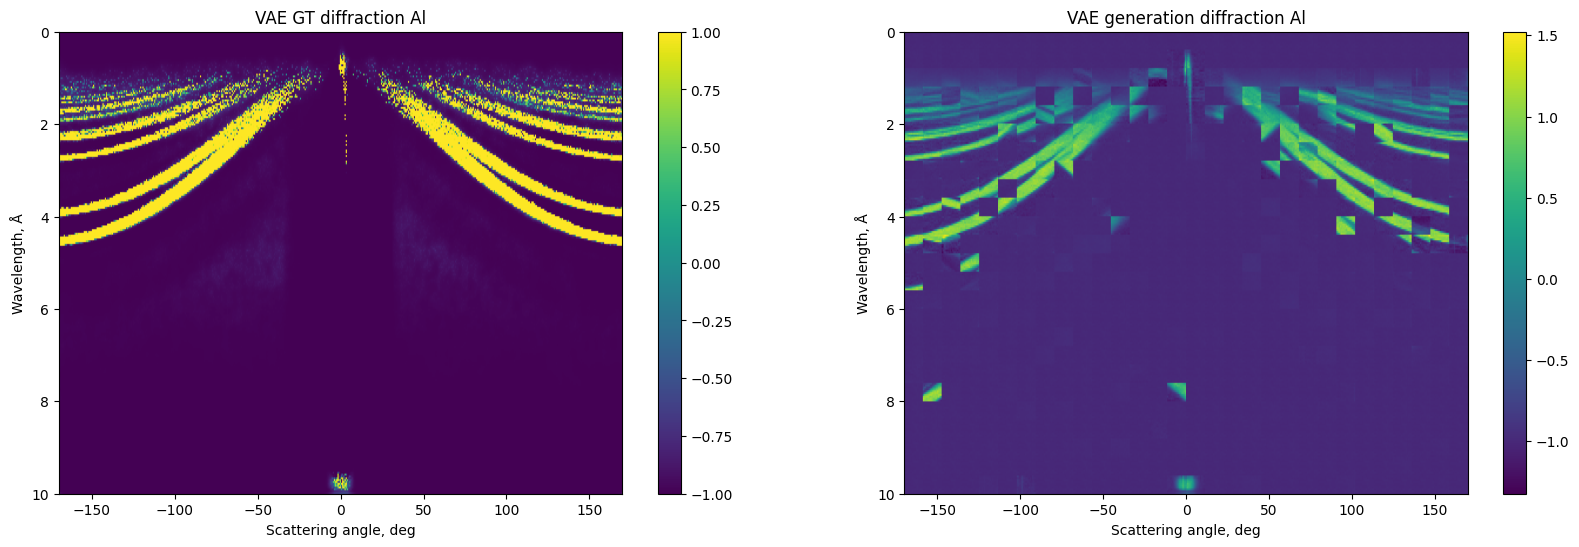

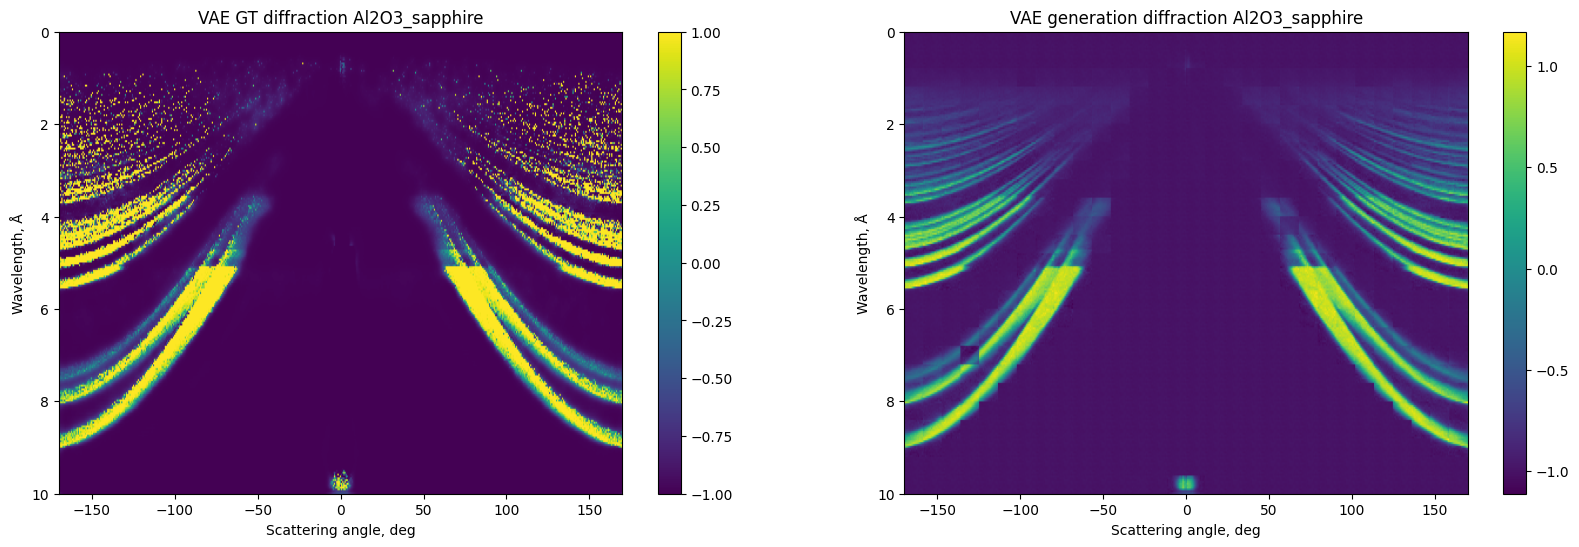

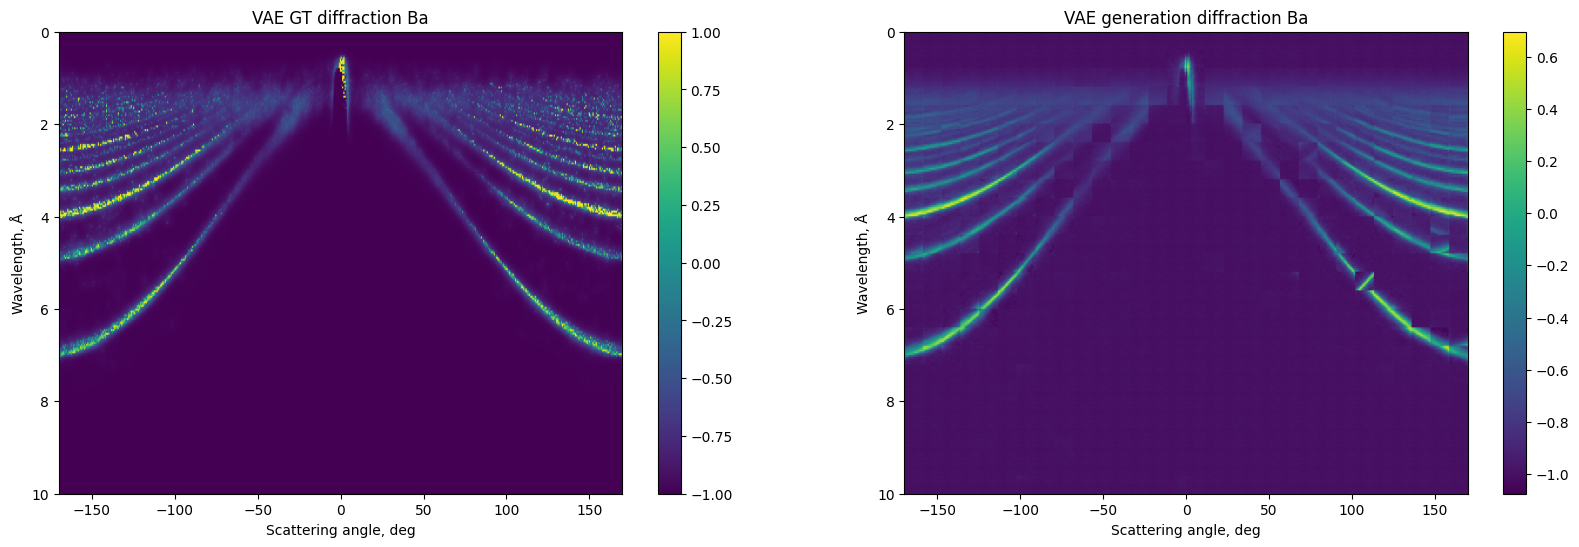

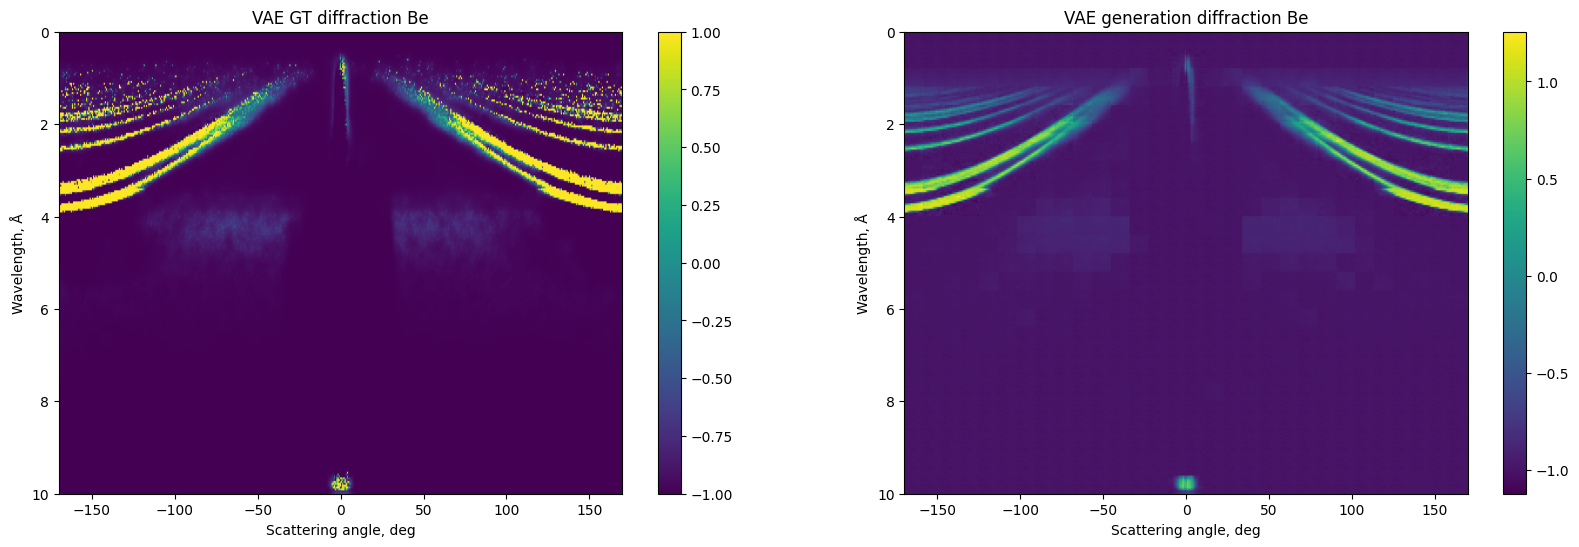

In [20]:
import matplotlib.pyplot as plt

generated_diffractions = generated.squeeze().cpu().numpy()
gt_diffractions = df_test_tensor.squeeze().cpu().numpy()


for i, (generated_diffraction, gt_diffraction) in enumerate(zip(generated_diffractions, gt_diffractions[:4])):
    # Создаем фигуру и оси
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Первый график
    im1 = ax1.imshow(gt_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax1.set_title(f"VAE GT diffraction {Crystal_tags.tolist()[i]}")
    ax1.set_xlabel('Scattering angle, deg')
    ax1.set_ylabel('Wavelength, Å')
    plt.colorbar(im1)

    # Первый график
    im2 = ax2.imshow(generated_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax2.set_title(f"VAE generation diffraction {Crystal_tags.tolist()[i]}")
    ax2.set_xlabel('Scattering angle, deg')
    ax2.set_ylabel('Wavelength, Å')
    plt.colorbar(im2)

    # plt.savefig(f'VAE Results/{Crystal_tags.tolist()[i]} Diffraction VAE.jpg')

    plt.show()

100%|██████████| 162/162 [00:25<00:00,  6.37it/s]
c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, arg

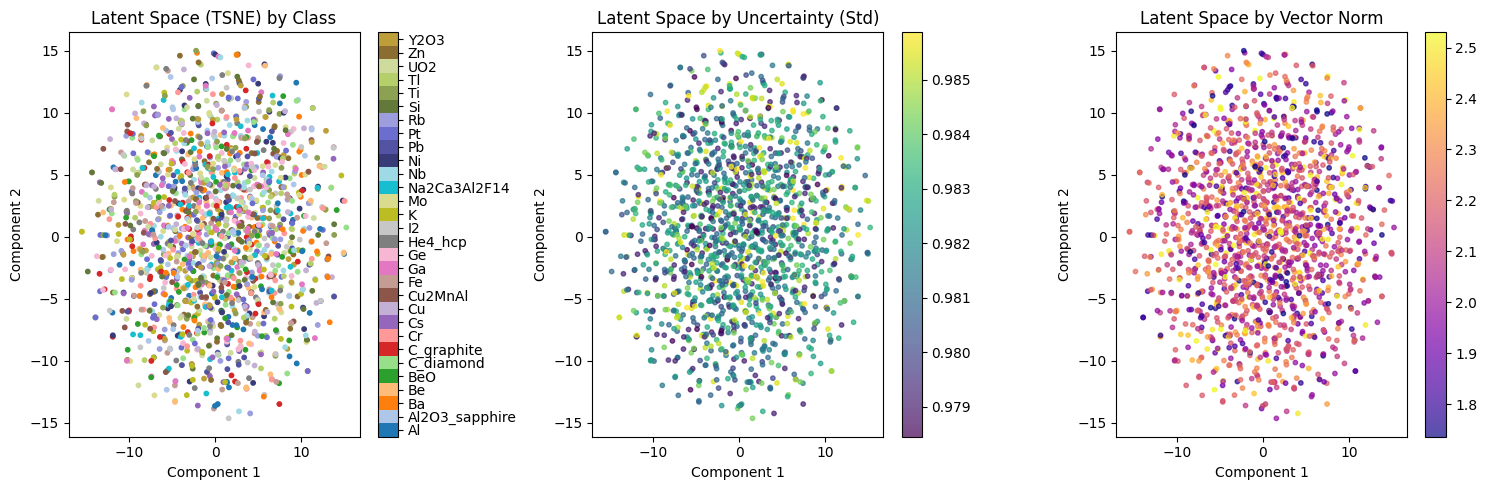

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

def visualize_latent_space(model, dataloader, device, method='tsne', class_names=None):
    model.eval()
    all_latents = []
    all_labels = []
    all_means = []
    all_logvars = []

    with torch.no_grad():
        for data, labels in tqdm(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            mean, logvar = model.encoder(data, labels)
            z = model.reparameterize(mean, logvar)

            all_latents.append(z.cpu().numpy())
            all_means.append(mean.cpu().numpy())
            all_logvars.append(logvar.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_latents = np.vstack(all_latents)
    all_means = np.vstack(all_means)
    all_labels = np.concatenate(all_labels)

    # Выбор метода снижения размерности
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)

    latents_2d = reducer.fit_transform(all_latents)

    # Визуализация
    plt.figure(figsize=(15, 5))

    plt.subplot(131)

    # Получаем уникальные классы и их количество
    unique_labels = np.unique(all_labels)
    n_classes = len(unique_labels)

    base_colors = (
        list(plt.cm.tab20.colors) +
        list(plt.cm.tab20b.colors) +
        list(plt.cm.tab20c.colors)
    )

    cmap = ListedColormap(base_colors[:n_classes])

    scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1],
                         c=all_labels,
                         cmap=cmap,
                         s=10,
                         vmin=-0.5,
                         vmax=n_classes-0.5)

    # Создаем colorbar с названиями классов
    cbar = plt.colorbar(scatter, ticks=range(n_classes))

    # Если переданы названия классов, используем их
    if class_names is not None:
        # Проверяем, что количество названий соответствует количеству классов
        if len(class_names) >= n_classes:
            cbar.ax.set_yticklabels([class_names[i] for i in range(n_classes)])
        else:
            print(f"Предупреждение: class_names содержит {len(class_names)} элементов, но есть {n_classes} классов")
            # Используем индексы как fallback
            cbar.ax.set_yticklabels([str(i) for i in range(n_classes)])
    else:
        # Если названий нет, используем просто индексы
        cbar.ax.set_yticklabels([str(i) for i in range(n_classes)])

    plt.title(f'Latent Space ({method.upper()}) by Class')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.subplot(132)
    # Визуализация неопределенности (std = exp(0.5 * logvar))
    stds = np.exp(0.5 * np.vstack(all_logvars)).mean(axis=1)
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=stds,
                         cmap='viridis', alpha=0.7, s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space by Uncertainty (Std)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.subplot(133)
    # Нормы латентных векторов
    norms = np.linalg.norm(all_means, axis=1)
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=norms,
                         cmap='plasma', alpha=0.7, s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space by Vector Norm')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()

    return all_latents, all_labels, latents_2d

# Использование
latents, labels, latents_2d = visualize_latent_space(model, train_loader, device, method='tsne', class_names=crystals)

In [17]:
#array([1.e+07, 2.e+07, 5.e+07, 1.e+08, 2.e+08, 5.e+08])
maxStats = 5.e+08
minI = max(df['Pulce duration'].unique())

df_test = df.loc[((df['Stats'] == maxStats) & (df['Pulce duration'] == minI))]
df_test = df_test.reset_index(drop= True)

Crystal_tags = df_test['Crystal']

Crystal_tags_encoded = label_encoder.fit_transform(Crystal_tags)

Crystal_tags_encoded = torch.LongTensor(Crystal_tags_encoded)
Crystal_tags_encoded = Crystal_tags_encoded.to(device)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor * 2.0 - 1.0

df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())
print(Crystal_tags_encoded.size())

df_test_tensor = df_test_tensor.to(device)

torch.Size([30, 1, 250, 480])
torch.Size([30])


In [18]:
labels = torch.LongTensor([0, 1, 2, 3]).to(device)

model.eval()
with torch.no_grad():
    # Sample from prior distribution
    z = torch.randn(4, 256).to(device)

    generated = model.decoder(z, labels)

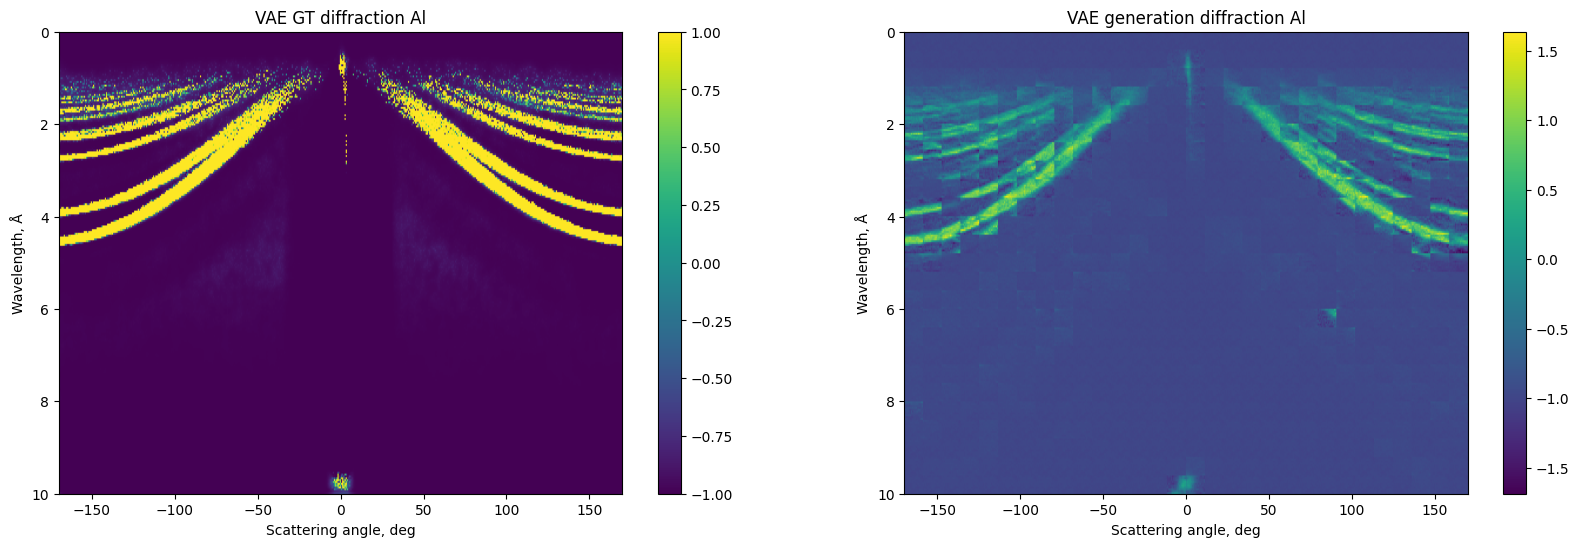

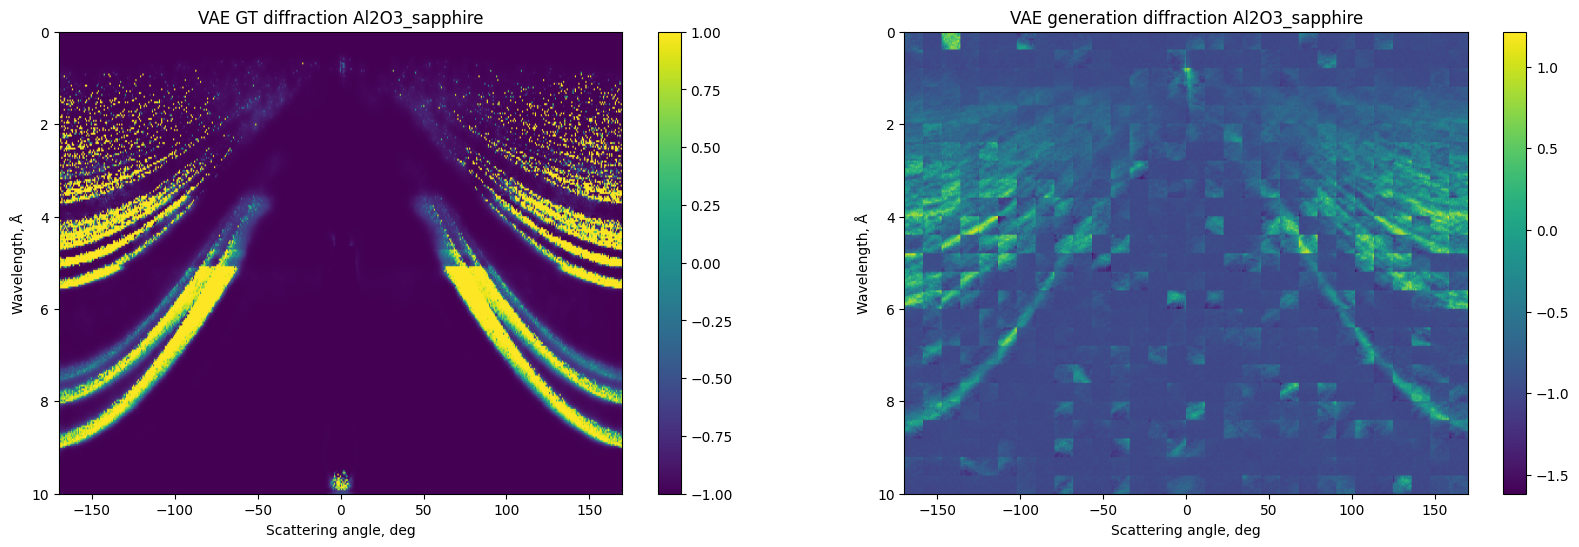

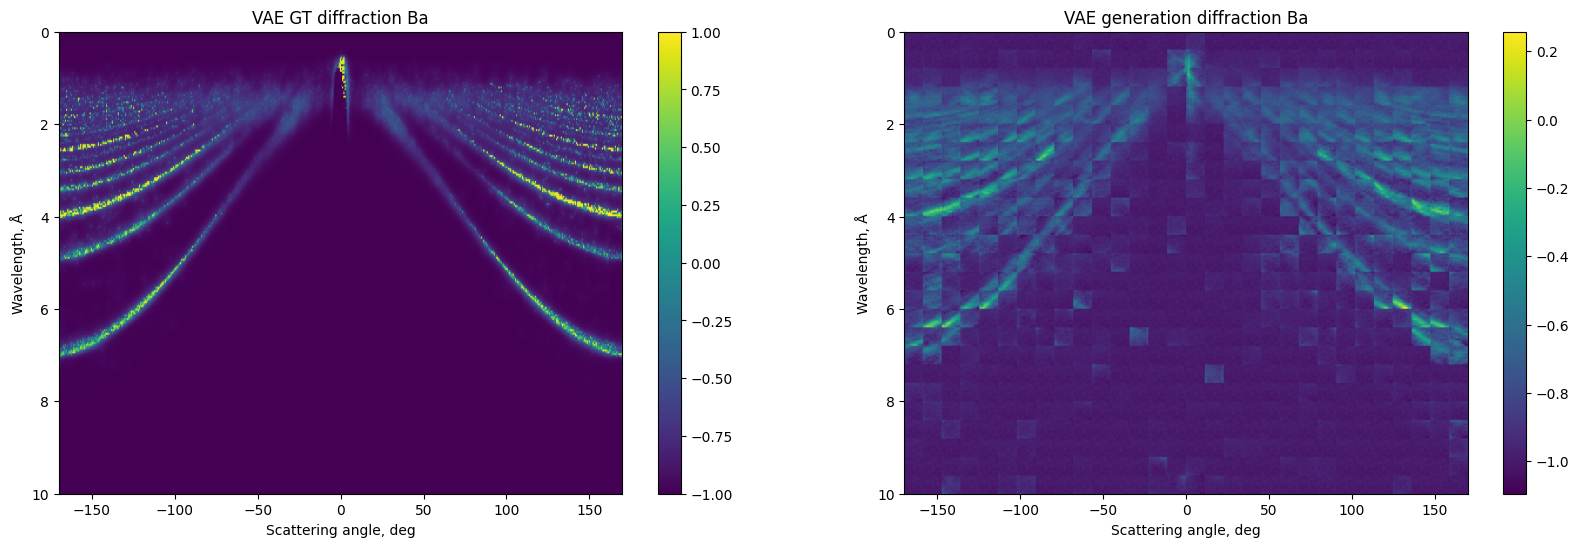

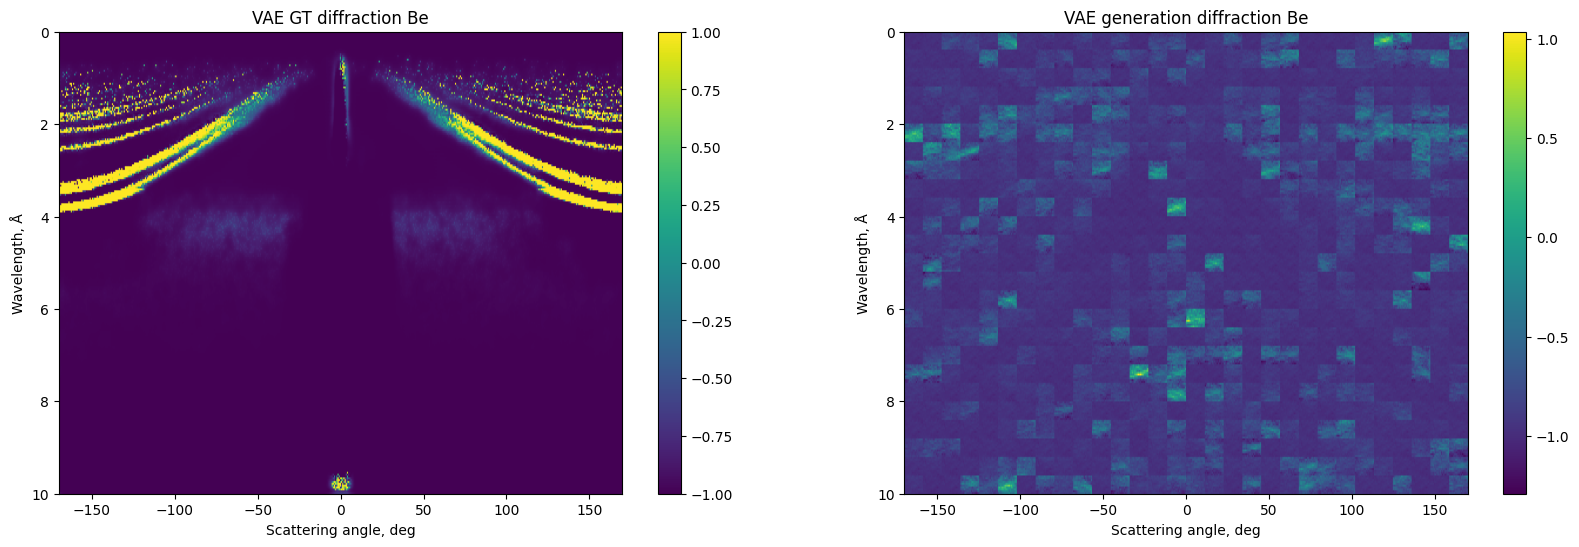

In [19]:
import matplotlib.pyplot as plt

generated_diffractions = generated.squeeze().cpu().numpy()
gt_diffractions = df_test_tensor.squeeze().cpu().numpy()


for i, (generated_diffraction, gt_diffraction) in enumerate(zip(generated_diffractions, gt_diffractions[:4])):
    # Создаем фигуру и оси
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Первый график
    im1 = ax1.imshow(gt_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax1.set_title(f"VAE GT diffraction {Crystal_tags.tolist()[i]}")
    ax1.set_xlabel('Scattering angle, deg')
    ax1.set_ylabel('Wavelength, Å')
    plt.colorbar(im1)

    # Первый график
    im2 = ax2.imshow(generated_diffraction, cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
    ax2.set_title(f"VAE generation diffraction {Crystal_tags.tolist()[i]}")
    ax2.set_xlabel('Scattering angle, deg')
    ax2.set_ylabel('Wavelength, Å')
    plt.colorbar(im2)

    # plt.savefig(f'VAE Results/{Crystal_tags.tolist()[i]} Diffraction VAE.jpg')

    plt.show()